# Big_Event_Classifier

# Import packages and Datasets

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
from keras import models
from keras import layers
from keras.layers import LSTM

import gc #Garbage Collector interface
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score #The F-Measure is a popular metric for imbalanced classification.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# import Google Drive 套件
from google.colab import drive

# 將自己的雲端硬碟掛載上去
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# 透過 gdrive/My Drive/... 來存取檔案
data_df = pd.read_excel('gdrive/My Drive/金融科技Final_project/2019+2020年新聞資訊事件(5.28).xlsx')

In [4]:
data_df.head()

,個股代號,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容,Unnamed: 8,content_tokenized
0,1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,19.0,發言人 林俐婉 內部 調動 由 江巍峰 接任
1,1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,22.0,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
2,1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,20.0,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
3,1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,22.0,內部 稽核 主管 游本詮 內部 調動 由 曾筱茜 接任
4,1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,20.0,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任


## Define "preprocess_text" functions

In [0]:
def preprocess_text(corpus, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1000):
  tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
  tokenizer.fit_on_texts(corpus)
  output = tokenizer.texts_to_sequences(corpus)
  output = keras .preprocessing .sequence .pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
  return output

## Data preprocessing

In [0]:
x = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["事件強度"]

In [7]:
y.value_counts()

-1    19563
 0    10526
 1     5355
-2      810
-3      296
 2       94
 3       73
Name: 事件強度, dtype: int64

## Split data into training dataset and testing dataset

In [8]:
# Split data to training data and testing data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_par_train, X_val, y_par_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate class weights

print(np.unique(y_train))

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print(class_weights)

[-3 -2 -1  0  1  2  3]
[18.48521082  6.3005148   0.26870792  0.49930305  0.97268031 51.17247387
 65.56473214]


In [0]:
# One-hot encoding
enc = OneHotEncoder(sparse=False)
y_train = enc.fit(np.asarray(y).reshape(-1, 1))
y_par_train = enc.transform(np.asarray(y_par_train).reshape(-1, 1))
y_val = enc.transform(np.asarray(y_val).reshape(-1, 1))
y_test = enc.transform(np.asarray(y_test).reshape(-1, 1))

In [10]:
enc.categories_

[array([-3, -2, -1,  0,  1,  2,  3])]

In [11]:
# save this encoder
from joblib import dump, load
dump(enc, 'gdrive/My Drive/金融科技Final_project/Intensity_enc.joblib') 

['gdrive/My Drive/金融科技Final_project/Intensity_enc.joblib']

In [12]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_par_train_res, y_par_train_res = ros.fit_resample(X_par_train, y_par_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Model 1: 

Reduce the units of LSTM to 32

Use Random Oversampling

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 87542 samples, validate on 5875 samples
Epoch 1/10
87542/87542 [==============================] - 365s 4ms/step - loss: 0.7026 - accuracy: 0.8335 - val_loss: 0.4027 - val_accuracy: 0.8672
Epoch 2/10
87542/87542 [==============================] - 359s 4ms/step - loss: 0.1202 - accuracy: 0.9659 - val_loss: 0.3757 - val_accuracy: 0.8809
Epoch 3/10
87542/87542 [==============================] - 357s 4ms/step - loss: 0.0743 - accuracy: 0.9790 - val_loss: 0.4430 - val_accuracy: 0.8645
Epoch 4/10
87542/87542 [==============================] - 358s 4ms/step - loss: 0.0533 - accuracy: 0.9853 - val_loss: 0.4110 - val_accuracy: 0.8851
Epoch 5/10
87542/87542 [==============================] - 357s 4ms/step - loss: 0.0345 - accuracy: 0.9914 - val_loss: 0.4395 - val_accuracy: 0.8871
Epoch 6/10
87542/87542 [==============================] - 357s 4ms/step - loss: 0.0274 - accuracy: 0.9928 - val_loss: 0.4634 - val_accuracy: 0.8919
Epoch 7/10
87542/87542 [==============================] - 357s 

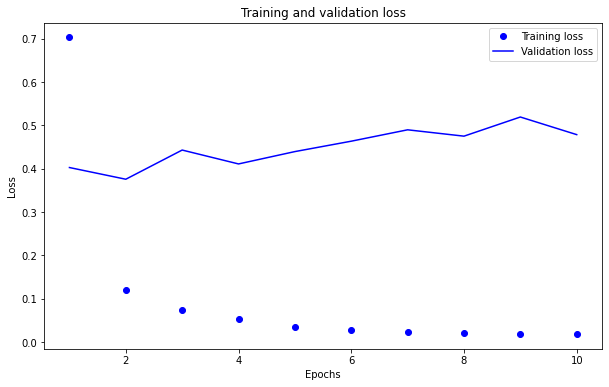

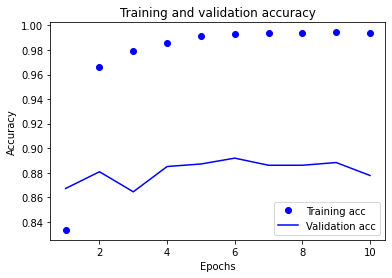

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Embedding(10000, 128)) #256
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_1.add(layers.LSTM(32,dropout=0,recurrent_dropout=0)) #128
model_1.add(layers.Dense(7, activation='softmax'))

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_1.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_1.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

## Performance on testing set

In [0]:
preds_Y_test = model_1.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

# Model 2: 

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 87542 samples, validate on 5875 samples
Epoch 1/10
87542/87542 [==============================] - 625s 7ms/step - loss: 0.9166 - accuracy: 0.8106 - val_loss: 0.4586 - val_accuracy: 0.8512
Epoch 2/10
87542/87542 [==============================] - 621s 7ms/step - loss: 0.1496 - accuracy: 0.9616 - val_loss: 0.3672 - val_accuracy: 0.8802
Epoch 3/10
87542/87542 [==============================] - 616s 7ms/step - loss: 0.0779 - accuracy: 0.9807 - val_loss: 0.3925 - val_accuracy: 0.8766
Epoch 4/10
87542/87542 [==============================] - 611s 7ms/step - loss: 0.0511 - accuracy: 0.9871 - val_loss: 0.4122 - val_accuracy: 0.8832
Epoch 5/10
87542/87542 [==============================] - 617s 7ms/step - loss: 0.0358 - accuracy: 0.9912 - val_loss: 0.4159 - val_accuracy: 0.8875
Epoch 6/10
87542/87542 [==============================] - 617s 7ms/step - loss: 0.0298 - accuracy: 0.9924 - val_loss: 0.4389 - val_accuracy: 0.8892
Epoch 7/10
87542/87542 [==============================] - 604s 

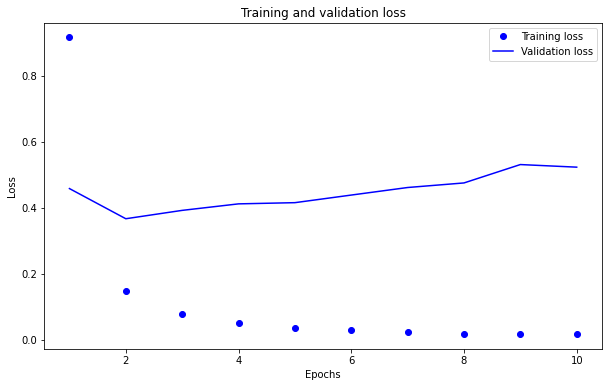

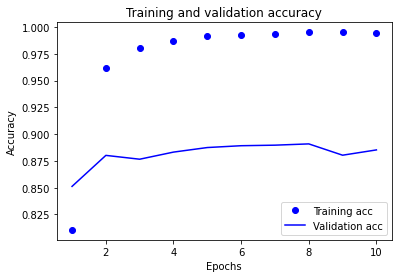

In [0]:
model_2 = models.Sequential()
model_2.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_2.add(layers.LSTM(16,dropout=0,recurrent_dropout=0))
model_2.add(layers.Dense(7, activation='softmax'))

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_2.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_2.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9896161375436208

precision: [0.80357143 0.97619048 0.99573475 0.98456515 0.9912816  1.
 1.        ]

recall: [1.         0.99440299 0.9893651  0.9864684  0.99504084 1.
 1.        ]

F1 score: [0.89108911 0.98521257 0.99253971 0.98551586 0.99315766 1.
 1.        ]

Confusion matrix: 
[[  180     0     0     0     0     0     0]
 [    2   533     0     1     0     0     0]
 [   26     7 12373    90    10     0     0]
 [   13     6    52  6634    20     0     0]
 [    3     0     1    13  3411     0     0]
 [    0     0     0     0     0    70     0]
 [    0     0     0     0     0     0    53]]


## Performance on testing set

In [0]:
preds_Y_test = model_2.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8782679738562091

precision: [0.38983051 0.54887218 0.94007021 0.84115695 0.8095723  0.8
 1.        ]

recall: [0.66666667 0.50694444 0.94983532 0.83600377 0.76368876 0.33333333
 1.        ]

F1 score: [0.49197861 0.52707581 0.94492754 0.83857244 0.78596144 0.47058824
 1.        ]

Confusion matrix: 
[[  46   10    6    6    1    0    0]
 [   9   73   40   17    4    1    0]
 [  25   31 3749  111   31    0    0]
 [  27   15  158 1774  148    0    0]
 [  11    3   34  198  795    0    0]
 [   0    1    1    3    3    4    0]
 [   0    0    0    0    0    0    9]]


# Model 3:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.1, recurrent dropout:0.1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 87542 samples, validate on 5875 samples
Epoch 1/10
87542/87542 [==============================] - 702s 8ms/step - loss: 0.9297 - accuracy: 0.8152 - val_loss: 0.5259 - val_accuracy: 0.8318
Epoch 2/10
87542/87542 [==============================] - 700s 8ms/step - loss: 0.1988 - accuracy: 0.9468 - val_loss: 0.3848 - val_accuracy: 0.8717
Epoch 3/10
87542/87542 [==============================] - 695s 8ms/step - loss: 0.1120 - accuracy: 0.9686 - val_loss: 0.3789 - val_accuracy: 0.8783
Epoch 4/10
87542/87542 [==============================] - 700s 8ms/step - loss: 0.0780 - accuracy: 0.9783 - val_loss: 0.3932 - val_accuracy: 0.8807
Epoch 5/10
87542/87542 [==============================] - 697s 8ms/step - loss: 0.0577 - accuracy: 0.9845 - val_loss: 0.4148 - val_accuracy: 0.8860
Epoch 6/10
87542/87542 [==============================] - 697s 8ms/step - loss: 0.0459 - accuracy: 0.9875 - val_loss: 0.4277 - val_accuracy: 0.8834
Epoch 7/10
87542/87542 [==============================] - 711s 

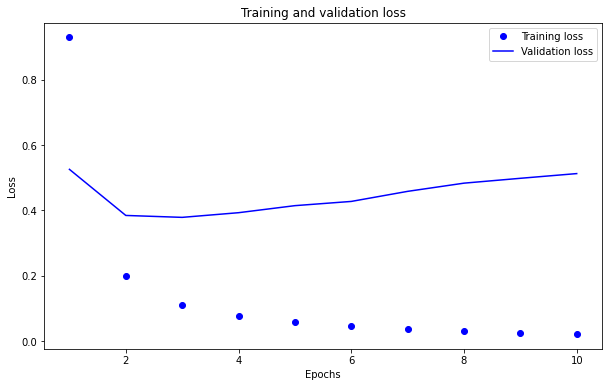

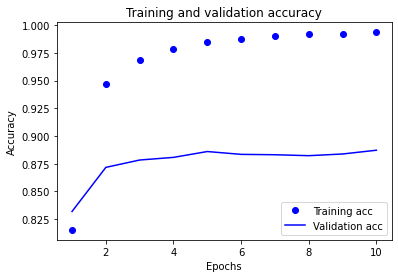

In [0]:
model_3 = models.Sequential()
model_3.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_3.add(layers.LSTM(16,dropout=0.1,recurrent_dropout=0.1))
model_3.add(layers.Dense(7, activation='softmax'))

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_3.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_3.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9880840922631713

precision: [0.7826087  0.9692029  0.99716783 0.9776766  0.99241097 1.
 1.        ]

recall: [1.         0.99813433 0.98536702 0.98988848 0.99183197 1.
 1.        ]

F1 score: [0.87804878 0.98345588 0.9912323  0.98374464 0.99212139 1.
 1.        ]

Confusion matrix: 
[[  180     0     0     0     0     0     0]
 [    1   535     0     0     0     0     0]
 [   36    11 12323   130     6     0     0]
 [   10     6    32  6657    20     0     0]
 [    3     0     3    22  3400     0     0]
 [    0     0     0     0     0    70     0]
 [    0     0     0     0     0     0    53]]


## Performance on testing set

In [0]:
preds_Y_test = model_3.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8752723311546841

precision: [0.36363636 0.58139535 0.95782665 0.80458756 0.81289641 0.83333333
 0.9       ]

recall: [0.63768116 0.52083333 0.93792754 0.85956645 0.73871278 0.41666667
 1.        ]

F1 score: [0.46315789 0.54945055 0.94777266 0.83116883 0.7740312  0.55555556
 0.94736842]

Confusion matrix: 
[[  44    8    7   10    0    0    0]
 [   7   75   29   28    5    0    0]
 [  22   28 3702  167   28    0    0]
 [  36   13  104 1824  143    1    1]
 [  11    5   21  235  769    0    0]
 [   1    0    2    3    1    5    0]
 [   0    0    0    0    0    0    9]]


# Model 4:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.15, recurrent dropout:0.15

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 87542 samples, validate on 5875 samples
Epoch 1/10
87542/87542 [==============================] - 670s 8ms/step - loss: 0.9104 - accuracy: 0.8066 - val_loss: 0.5129 - val_accuracy: 0.8349
Epoch 2/10
87542/87542 [==============================] - 670s 8ms/step - loss: 0.1959 - accuracy: 0.9479 - val_loss: 0.3927 - val_accuracy: 0.8633
Epoch 3/10
87542/87542 [==============================] - 706s 8ms/step - loss: 0.1122 - accuracy: 0.9674 - val_loss: 0.3821 - val_accuracy: 0.8769
Epoch 4/10
87542/87542 [==============================] - 680s 8ms/step - loss: 0.0803 - accuracy: 0.9765 - val_loss: 0.3958 - val_accuracy: 0.8807
Epoch 5/10
87542/87542 [==============================] - 687s 8ms/step - loss: 0.0618 - accuracy: 0.9821 - val_loss: 0.4111 - val_accuracy: 0.8822
Epoch 6/10
87542/87542 [==============================] - 693s 8ms/step - loss: 0.0490 - accuracy: 0.9861 - val_loss: 0.4274 - val_accuracy: 0.8819
Epoch 7/10
87542/87542 [==============================] - 675s 

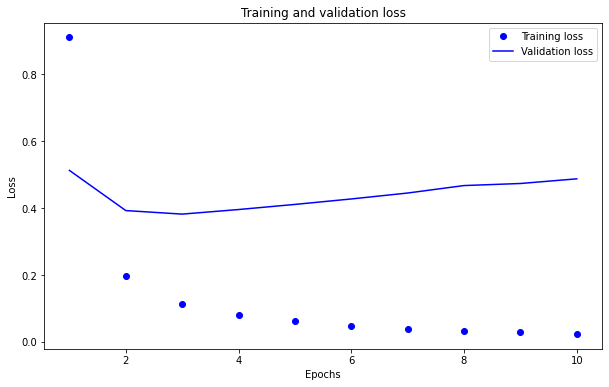

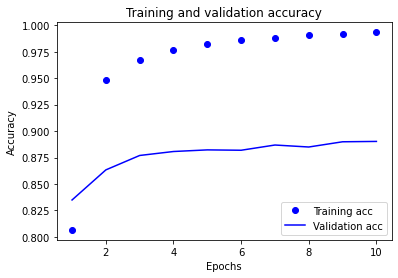

In [0]:
model_4 = models.Sequential()
model_4.add(layers.Embedding(10000, 128))
# model_1.add(layers.LSTM(128,dropout=0.2,recurrent_dropout=0.2,return_sequences=True))
model_4.add(layers.LSTM(16,dropout=0.15,recurrent_dropout=0.15))
model_4.add(layers.Dense(7, activation='softmax'))

model_4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_4.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_4.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9874457400629841

precision: [0.8        0.9692029  0.99684594 0.97902821 0.98497978 1.
 1.        ]

recall: [1.         0.99813433 0.98560691 0.98572491 0.99474912 1.
 1.        ]

F1 score: [0.88888889 0.98345588 0.99119456 0.98236515 0.98984035 1.
 1.        ]

Confusion matrix: 
[[  180     0     0     0     0     0     0]
 [    1   535     0     0     0     0     0]
 [   20    13 12326   130    17     0     0]
 [   19     4    38  6629    35     0     0]
 [    5     0     1    12  3410     0     0]
 [    0     0     0     0     0    70     0]
 [    0     0     0     0     0     0    53]]


## Performance on testing set

In [0]:
preds_Y_test = model_4.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8785403050108932

precision: [0.46601942 0.64227642 0.95145631 0.81789137 0.79638917 0.85714286
 1.        ]

recall: [0.69565217 0.54861111 0.94350139 0.84448633 0.76272815 0.5
 1.        ]

F1 score: [0.55813953 0.5917603  0.94746215 0.83097612 0.77919529 0.63157895
 1.        ]

Confusion matrix: 
[[  48    7    7    6    1    0    0]
 [   6   79   30   25    4    0    0]
 [  17   25 3724  150   31    0    0]
 [  21   10  134 1792  164    1    0]
 [  11    2   18  216  794    0    0]
 [   0    0    1    2    3    6    0]
 [   0    0    0    0    0    0    9]]


# Model 5:

Reduce the units of LSTM to 16

Use Random Oversampling

sequence length = 1305 (max length of our text data)

Drop: 0.2, recurrent dropout:0.2

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 87542 samples, validate on 5875 samples
Epoch 1/10
87542/87542 [==============================] - 671s 8ms/step - loss: 0.9350 - accuracy: 0.7918 - val_loss: 0.5254 - val_accuracy: 0.8407
Epoch 2/10
87542/87542 [==============================] - 673s 8ms/step - loss: 0.2206 - accuracy: 0.9446 - val_loss: 0.3962 - val_accuracy: 0.8735
Epoch 3/10
87542/87542 [==============================] - 664s 8ms/step - loss: 0.1242 - accuracy: 0.9657 - val_loss: 0.4017 - val_accuracy: 0.8698
Epoch 4/10
87542/87542 [==============================] - 660s 8ms/step - loss: 0.0894 - accuracy: 0.9747 - val_loss: 0.3927 - val_accuracy: 0.8819
Epoch 5/10
87542/87542 [==============================] - 670s 8ms/step - loss: 0.0684 - accuracy: 0.9801 - val_loss: 0.4150 - val_accuracy: 0.8768
Epoch 6/10
87542/87542 [==============================] - 677s 8ms/step - loss: 0.0540 - accuracy: 0.9839 - val_loss: 0.4255 - val_accuracy: 0.8814
Epoch 7/10
87542/87542 [==============================] - 669s 

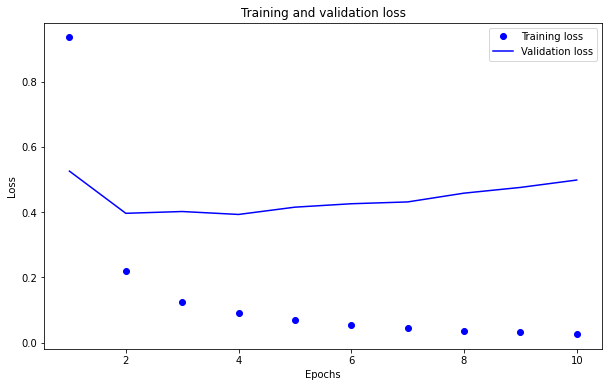

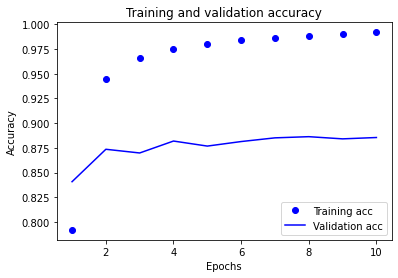

In [0]:
model_5 = models.Sequential()
model_5.add(layers.Embedding(10000, 128))
model_5.add(layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
model_5.add(layers.Dense(7, activation='softmax'))

model_5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_5.fit(X_par_train_res, y_par_train_res,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val)
                    #class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_5.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9855306834624223

precision: [0.68441065 0.97090909 0.99595731 0.9782319  0.98721302 1.
 1.        ]

recall: [1.         0.99626866 0.98496722 0.98230483 0.99095683 1.
 1.        ]

F1 score: [0.81264108 0.98342541 0.99043178 0.98026413 0.98908138 1.
 1.        ]

Confusion matrix: 
[[  180     0     0     0     0     0     0]
 [    2   534     0     0     0     0     0]
 [   42    11 12318   126     9     0     0]
 [   31     5    48  6606    35     0     0]
 [    8     0     2    21  3397     0     0]
 [    0     0     0     0     0    70     0]
 [    0     0     0     0     0     0    53]]


## Performance on testing set

In [0]:
preds_Y_test = model_5.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8779956427015251

precision: [0.33333333 0.62903226 0.95723854 0.82854495 0.7885939  0.85714286
 1.        ]

recall: [0.71014493 0.54166667 0.94147454 0.84260132 0.77041306 0.5
 1.        ]

F1 score: [0.4537037  0.58208955 0.9492911  0.83551402 0.77939747 0.63157895
 1.        ]

Confusion matrix: 
[[  49    5    6    9    0    0    0]
 [   8   78   25   25    8    0    0]
 [  37   24 3716  136   33    1    0]
 [  37   13  113 1788  171    0    0]
 [  16    4   21  198  802    0    0]
 [   0    0    1    2    3    6    0]
 [   0    0    0    0    0    0    9]]


# Model 6:

Adjust class weights

sequence length = 1305 (max length of our text data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23498 samples, validate on 5875 samples
Epoch 1/10
23498/23498 [==============================] - 159s 7ms/step - loss: 1.2299 - accuracy: 0.5926 - val_loss: 0.6635 - val_accuracy: 0.7583
Epoch 2/10
23498/23498 [==============================] - 158s 7ms/step - loss: 0.4709 - accuracy: 0.8465 - val_loss: 0.3923 - val_accuracy: 0.8623
Epoch 3/10
23498/23498 [==============================] - 157s 7ms/step - loss: 0.3106 - accuracy: 0.8914 - val_loss: 0.3646 - val_accuracy: 0.8717
Epoch 4/10
23498/23498 [==============================] - 157s 7ms/step - loss: 0.2358 - accuracy: 0.9193 - val_loss: 0.3772 - val_accuracy: 0.8628
Epoch 5/10
23498/23498 [==============================] - 155s 7ms/step - loss: 0.1853 - accuracy: 0.9371 - val_loss: 0.3948 - val_accuracy: 0.8740
Epoch 6/10
23498/23498 [==============================] - 156s 7ms/step - loss: 0.1540 - accuracy: 0.9474 - val_loss: 0.4063 - val_accuracy: 0.8700
Epoch 7/10
23498/23498 [==============================] - 155s 

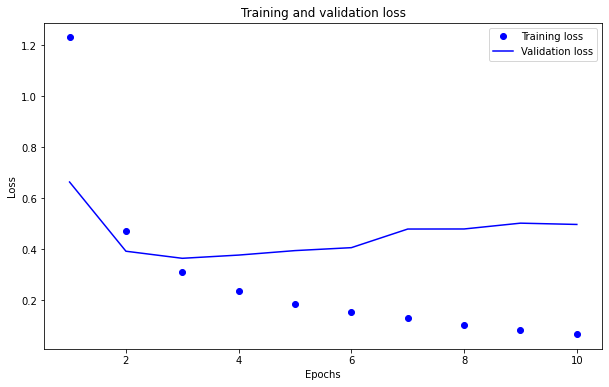

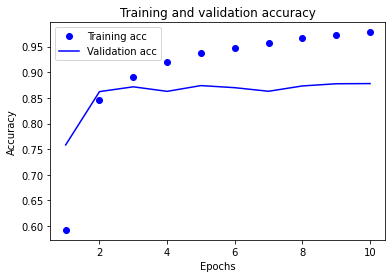

In [13]:
model_6 = models.Sequential()
model_6.add(layers.Embedding(10000, 128))
model_6.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_6.add(layers.Dense(32, activation='relu'))
model_6.add(layers.Dense(32, activation='relu'))
model_6.add(layers.Dense(7, activation='softmax'))

model_6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_6.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [14]:
preds_Y_par_train = model_6.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.9812324453144948

precision: [0.47761194 0.91344383 0.99414407 0.9835336  0.98968768 1.
 0.        ]

recall: [0.88888889 0.92537313 0.99096434 0.98587361 0.97987165 0.27142857
 0.        ]

F1 score: [0.62135922 0.91936979 0.99255166 0.98470221 0.9847552  0.42696629
 0.        ]

Confusion matrix: 
[[  160    19     0     1     0     0     0]
 [   28   496     6     6     0     0     0]
 [   22    10 12393    72     9     0     0]
 [   25     3    42  6630    25     0     0]
 [   11     1    25    32  3359     0     0]
 [   38    12     0     0     1    19     0]
 [   51     2     0     0     0     0     0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Performance on testing set

In [15]:
preds_Y_test = model_6.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

accuracy: 0.8733660130718954

precision: [0.40909091 0.61666667 0.94778603 0.80618102 0.81316348 0.
 0.        ]

recall: [0.65217391 0.51388889 0.9381809  0.86050895 0.73583093 0.
 0.        ]

F1 score: [0.5027933  0.56060606 0.942959   0.83245954 0.77256682 0.
 0.        ]

Confusion matrix: 
[[  45   10    5    9    0    0    0]
 [   8   74   25   31    6    0    0]
 [  15   22 3703  176   31    0    0]
 [  20    8  133 1826  135    0    0]
 [  11    3   40  221  766    0    0]
 [   2    3    1    2    4    0    0]
 [   9    0    0    0    0    0    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 7:

ADJUST CLASS WEIGHTS

Use "Dropout" for dense layers

sequence length = 1305 (max length of our text data)

In [0]:
model_7 = models.Sequential()
model_7.add(layers.Embedding(10000, 128))
model_7.add(layers.LSTM(64,dropout=0,recurrent_dropout=0))
model_7.add(layers.Dense(32, activation='relu'))
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Dense(32, activation='relu'))
model_7.add(layers.Dropout(0.2))
model_7.add(layers.Dense(7, activation='softmax'))

model_7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
history = model_7.fit(X_par_train, y_par_train,
                    epochs=10,
                    batch_size=500,
                    validation_data = (X_val,y_val),
                    class_weight = class_weights
                    )

# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Performance on partial training set

In [0]:
preds_Y_par_train = model_7.predict(X_par_train)
preds_Y_par_train =(preds_Y_par_train>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_par_train_copy = enc.inverse_transform(preds_Y_par_train)
y_par_train_copy = enc.inverse_transform(y_par_train)

accuracy = accuracy_score(y_par_train_copy, preds_Y_par_train_copy)
precision = precision_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_par_train_copy, preds_Y_par_train_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')

c_matrix = confusion_matrix(y_par_train_copy, preds_Y_par＿train_copy,labels=[-3,-2,-1,0,1,2,3])
print('Confusion matrix: ')
print(c_matrix)

## Performance on testing set

In [0]:
preds_Y_test = model_7.predict(X_test)
preds_Y_test =(preds_Y_test>0.5).astype(int)

# decode categorical dummy variables to categorical variables
preds_Y_test_copy = enc.inverse_transform(preds_Y_test)
y_test_copy = enc.inverse_transform(y_test)

accuracy = accuracy_score(y_test_copy, preds_Y_test_copy)
precision = precision_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None) # average=None: The precision scores for each class are returned
recall = recall_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
f1 = f1_score(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3],average=None)
c_matrix = confusion_matrix(y_test_copy, preds_Y_test_copy,labels=[-3,-2,-1,0,1,2,3])
print('accuracy: '+str(accuracy)+'\n')
print('precision: '+str(precision)+'\n')
print('recall: '+str(recall)+'\n')
print('F1 score: '+str(f1)+'\n')
print('Confusion matrix: ')
print(c_matrix)

# Use all data to train our final Intensity_Event_Classifier

## Use model 5 as our final model

In [0]:
x = preprocess_text(corpus = data_df.content_tokenized, MAX_NUM_WORDS = 10000, MAX_SEQUENCE_LENGTH = 1305)

y = data_df["事件強度"]

# Calculate class weights

print(np.unique(y))

class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)

print(class_weights)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(np.asarray(y).reshape(-1, 1))

# Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
x, y = ros.fit_resample(x, y)

[-3 -2 -1  0  1  2  3]
[17.72055985  6.47566138  0.26812277  0.49831709  0.9795118  55.80091185
 71.85322896]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
model = models.Sequential()
model.add(layers.Embedding(10000, 128))
model.add(layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Iterate on your training data by calling the fit() method of your model
model.fit(x, y,epochs=10,batch_size=500)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
136941/136941 [==============================] - 695s 5ms/step - loss: 0.6919 - accuracy: 0.8367
Epoch 2/10
136941/136941 [==============================] - 695s 5ms/step - loss: 0.1588 - accuracy: 0.9516
Epoch 3/10
136941/136941 [==============================] - 688s 5ms/step - loss: 0.1022 - accuracy: 0.9682
Epoch 4/10
136941/136941 [==============================] - 680s 5ms/step - loss: 0.0758 - accuracy: 0.9768
Epoch 5/10
136941/136941 [==============================] - 688s 5ms/step - loss: 0.0600 - accuracy: 0.9818
Epoch 6/10
136941/136941 [==============================] - 690s 5ms/step - loss: 0.0502 - accuracy: 0.9852
Epoch 7/10
136941/136941 [==============================] - 705s 5ms/step - loss: 0.0415 - accuracy: 0.9874
Epoch 8/10
136941/136941 [==============================] - 691s 5ms/step - loss: 0.0359 - accuracy: 0.9892
Epoch 9/10
136941/136941 [==============================] - 681s 5ms/step - loss: 0.0311 - accuracy: 0.9906
Epoch 10/10
136941/136941 [=

# Save Big_Event_Classifier

In [0]:
# SAVE MODEL
model.save('gdrive/My Drive/金融科技Final_project/Intensity_Classifier')